# 1. Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from multiprocessing import Pool
from preprocess_data import preprocess_data
from functools import partial
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import csv

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Normalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.optimizers import Adam

c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [2]:
# Check GPU is detected
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Import Data

Import stock price data

In [3]:
# Import data
stock_prices_df = pd.read_csv("data/price.csv")

# Set date-time index
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df["Date"], format='%Y-%m-%d')
stock_prices_df = stock_prices_df.set_index(stock_prices_df['Date'])
stock_prices_df = stock_prices_df.drop(columns = ["Date"])

# Drop all columns which only contain nan values
boolean = []
for stock in stock_prices_df.columns:
    boolean.append(not stock_prices_df[stock].isnull().all())
stock_prices_df = stock_prices_df.iloc[:, boolean]

stock_prices_df

,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACHC,...,YUM,Z,ZBH,ZBRA,ZG,ZI,ZION,ZM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,NaN,3.217068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,3.187954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,3.187954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,3.246180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,3.289852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,128.880005,26.809999,13.35,55.630001,189.429993,144.149994,133.699997,105.190002,81.989998,74.750000,...,125.650002,44.090000,116.889999,239.369995,42.330002,14.71,38.680000,68.160004,198.259995,182.119995
2023-12-05,127.879997,25.240000,13.13,53.160000,193.419998,144.570007,133.710007,104.349998,81.849998,74.209999,...,124.379997,44.290001,115.820000,234.360001,42.520000,14.48,37.389999,68.720001,198.910004,179.649994
2023-12-06,128.910004,25.120001,13.48,55.160000,192.320007,146.380005,135.309998,104.940002,79.970001,71.150002,...,124.809998,45.090000,116.129997,234.130005,43.490002,15.50,37.150002,70.940002,197.910004,182.000000


Import categorical features

In [4]:
# Read data
cat_features = pd.read_csv("data/categorical.csv")
cat_features = cat_features.set_index("Unnamed: 0")
cat_features = cat_features.rename_axis(None, axis = 0)
cat_features = cat_features.dropna(axis="columns")

# Drop stocks such that the remaining stocks are those in both `cat_features` and `stock_prices_df`
intersection = list(set(stock_prices_df.columns) & set(cat_features.columns))
cat_features = cat_features[intersection]
stock_prices_df = stock_prices_df[intersection]

cat_features

,OTIS,POOL,MRVL,ABNB,NCNO,PLTK,MLM,JBGS,TNDM,TWKS,...,CMI,MRO,CMA,DEI,ICUI,LPLA,SO,WH,COP,PAYX
sectors,Industrials,Consumer Discretionary,Information Technology,Consumer Discretionary,Information Technology,Communication Services,Materials,Real Estate,Health Care,Information Technology,...,Industrials,Energy,Financials,Real Estate,Health Care,Financials,Utilities,Consumer Discretionary,Energy,Information Technology


In [5]:
# Get unique categories for each categorical variable
unique_cats_df = pd.DataFrame()
for cat in cat_features.index:
    uniques = list(cat_features.loc[cat, :].unique())
    categories = np.sort(uniques)
    unique_cats_df[cat] = categories

unique_cats_df

,sectors
0,Communication Services
1,Consumer Discretionary
2,Consumer Staples
3,Energy
4,Financials
5,Health Care
6,Industrials
7,Information Technology
8,Information technology
9,Materials


Import numerical features

In [6]:
# Read data
num_features = pd.read_csv("data/features.csv")
num_features['Date'] = pd.to_datetime(num_features["Date"], format='%Y-%m-%d')
num_features = num_features.set_index("Date")
num_features = num_features.dropna()

# Make names smaller and more manageable
print(num_features.columns)

num_features

Index(['BCI', 'CCI', 'CLI', '3 month interbank rate', 'Broad money',
       'Construction', 'Consumer prices', 'Manufacturing hourly earnings',
       'Industrial production', 'Long-term interest rate',
       'Manufacturing confidence indicator', 'Narrow money',
       'Overnight interbank rate', 'Car registrations',
       'Manufacturing producer prices', 'Retail trade volume',
       'Total employment', 'Total manufacturing'],
      dtype='object')


,BCI,CCI,CLI,3 month interbank rate,Broad money,Construction,Consumer prices,Manufacturing hourly earnings,Industrial production,Long-term interest rate,Manufacturing confidence indicator,Narrow money,Overnight interbank rate,Car registrations,Manufacturing producer prices,Retail trade volume,Total employment,Total manufacturing
Date,,,,,,,,,,,,,,,,,,
1990-01-01,98.82436,100.65310,99.79373,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-02,98.82436,100.65310,99.79373,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-03,98.82436,100.65310,99.79373,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-04,98.82436,100.65310,99.79373,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-05,98.82436,100.65310,99.79373,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,98.91187,97.06593,98.86258,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.042214,159300.0,97.682796
2022-12-24,98.91187,97.06593,98.86258,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.042214,159300.0,97.682796
2022-12-25,98.91187,97.06593,98.86258,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.042214,159300.0,97.682796


In [7]:
# Convert to numpy arrays for speedy opterations later on
stock_prices_np = stock_prices_df.to_numpy()
cat_features_np = cat_features.to_numpy()
features_daily_np = num_features.to_numpy()

# 3. Create Folders to Store Plots and Models

Create folders to store the models and corresponding plots showing the training process of each model.

In [8]:
root_folder = "results"
overview_folder = "overview"
details_folder = "details"

# Create a folder to store models and corresponding plots regarding training and validation details
graphs_path = f'{root_folder}/{details_folder}/training & validation details'
try:
    os.makedirs(graphs_path)
except FileExistsError:
    pass

models_path = f'{root_folder}/{details_folder}/models'
try:
    os.makedirs(models_path)
except FileExistsError:
    pass


# Create a csv file to store the hyperparameters used for each model as well as the corresponding loss and r-squared scores
try:
    os.makedirs(f"{root_folder}/{overview_folder}") # Create the folder where this csv file will be stored.
except FileExistsError:
    pass


model_results_path = f"{root_folder}/{overview_folder}/model results.csv"
try:
    results = pd.read_csv(model_results_path)
except FileNotFoundError:
    # If the file does not exist then we create the file
    with open(model_results_path, "w") as f:
        f.write(",".join(["features","lines", "years", "layers", "neurons per layer", "total neurons", "batch size", "technique", "model name","val_loss", "val_r2"]) + "\n")
    results = pd.read_csv(model_results_path)
results

,features,lines,years,layers,neurons per layer,total neurons,batch size,technique,model name,val_loss,val_r2
0,[sectors 3 month interbank rate BCI CCI CLI Ca...,5,2,2,16,32,1024,base,1,23.027020,0.875907
1,[sectors 3 month interbank rate BCI CCI CLI Ca...,5,2,2,32,64,1024,base,2,21.367506,0.892179
2,[sectors 3 month interbank rate BCI CCI CLI Ca...,5,2,4,16,64,1024,base,3,20.441135,0.893192
3,[sectors 3 month interbank rate BCI CCI CLI Ca...,5,2,4,32,128,1024,base,4,27.798033,0.886687
4,[sectors 3 month interbank rate BCI CCI CLI Ca...,5,2,6,16,96,1024,base,5,31.201929,0.867629
...,...,...,...,...,...,...,...,...,...,...,...
97,[],50,3,2,32,64,1024,base,98,23.914227,0.826351
98,[],50,3,4,16,64,1024,base,99,25.235209,0.790844
99,[],50,3,4,32,128,1024,base,100,25.023104,0.797549
100,[],50,3,6,16,96,1024,base,101,25.096287,0.776585


# 4. Function to Plot Training & Results of Each Model

This plot allows us to visualise the training process as well as visualise the predictions against the true values using a scatterplot. These plots are created for each model and can be found in `results\details\training & validation details`.

In [9]:
def plot(history, y_test, result_index, test_predictions, R2_score):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5), dpi=300)

    # PLot actual vs prediction scatter plot
    test_predictions = test_predictions.flatten()
    ax[0].scatter(y_test, test_predictions, alpha=0.01)
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predictions')

    # Plot y=x line
    y_equal_x_line = [0, max(max(y_test), max(test_predictions))]
    ax[0].plot(y_equal_x_line, y_equal_x_line, color="green", linewidth = 3)
    ax[0].set_title("Predictions Against True Values")
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')

    # Plot training and testing r-squared against epochs
    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label='val_loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Error')
    ax[1].set_title('loss')

    fig.suptitle(f"Val R2 = {R2_score}, Val loss={round(history.history['val_loss'][-1],3)}, result index={result_index}", fontsize="small")
    plt.legend()
    plt.grid(True)
    return fig

# 5. Function to Pre-process Data for the Model

The following function allows us to pre-process and create the data for the models using several different hyperparameters such as `number_of_lines`, `number_of_years_to_consider`, `cats_subset` and `features_subset`. 

In [10]:
def prepare_model_data(cat_features_subset, num_features_subset, number_of_years_to_consider,number_of_lines):
    # Sort for consistency
    cat_features_subset.sort()
    num_features_subset.sort()

    # Function to get the column-index of a given feature within the `num_features` df
    def get_num_features_index(feature):
        return list(num_features.columns).index(feature)
    # Function to get the column-index of a given feature within the `cat_features` df
    def get_cat_features_index(cat):
        return list(cat_features.index).index(cat)

    # Get corresponding column-indexes in `num_features` and `cat_features` for the numerical and categorical features which will be used to train the model 
    cats_subset_indexes = []
    for var in cat_features_subset:
        cats_subset_indexes.append(get_cat_features_index(var))
    features_subset_indexes = []
    for var in num_features_subset:
        features_subset_indexes.append(get_num_features_index(var))


    # Use multiprocessing with the hyperparameters `number_of_lines`, `number_of_years_to_consider`, `cats_subset` and `features_subset` 
    # in order to create the data for the model.
    range_iterations = range(number_of_years_to_consider*365+1, # `+1` needed since slicing is end-exclusive
                              len(stock_prices_np) - 365)
    iterations = tqdm(range_iterations,
                        desc=f"Working on Dataset: {number_of_lines} lines, {number_of_years_to_consider} years",
                        disable=False)
    p = Pool(os.cpu_count())
    result_list = p.map(partial(preprocess_data,
                                stocks_np = stock_prices_np,
                                number_of_years_to_consider = number_of_years_to_consider,
                                number_of_lines = number_of_lines,
                                features_subset_indexes = features_subset_indexes,
                                features_np = features_daily_np,
                                cats_np = cat_features_np,
                                cats_index = cats_subset_indexes,
                                cats_df = unique_cats_df,
                                dates = np.array(stock_prices_df.index),
                                stocks = np.array(stock_prices_df.columns)
                                ),
                        iterations)
    p.close()
    p.join()

    # Stack corresponding numpy arrays
    data = np.vstack([result[0] for result in result_list])
    data_dates = np.hstack([result[1] for result in result_list])
    data_stocks = np.hstack([result[2] for result in result_list])
    cats_dict = dict()
    for k in cats_subset_indexes:
        cats_dict[k] = np.hstack([result_list[i][3][k] for i in range(len(result_list))])
    features_dict = dict()
    for k in features_subset_indexes:
        features_dict[k] = np.vstack([result_list[i][4][k] for i in range(len(result_list))])

    # To prevent memory error
    del result_list

    # Convert the categorical features into dummy variables
    categorical_dummy_dfs_list = []
    for c in cats_subset_indexes:
        categorical_dummy_dfs_list.append(pd.get_dummies(cats_dict[c]).iloc[:,:-1])

    # Combine all the numpy arrays containg stock price data and features. (`[data]` must go last since the code expects the dependent variable to be the last column)
    model_data = np.hstack(categorical_dummy_dfs_list + [features_dict[f] for f in features_subset_indexes] + [data])
    del cats_dict, categorical_dummy_dfs_list, features_dict, data

    # Finally, covernt to a df
    index = pd.MultiIndex.from_tuples(list(zip(data_dates, data_stocks)), names=["dates", "stocks"])
    model_data = pd.DataFrame(model_data, index=index)

    # Normalize the features and apply PCA
    features = model_data.iloc[:, :-1]  
    print(f"Number of features before PCA: {len(features.columns)}")
    target = model_data.iloc[:, -1]  
    del model_data
    features_normalized = (features - features.mean()) / features.std()
    del features

    # Apply PCA
    pca = PCA(n_components=0.99)
    features_pca = pca.fit_transform(features_normalized)
    print(f"Number of features after PCA: {features_pca.shape[1]}")
    del features_normalized

    # Recombine the PCA-transformed features with the target
    model_data_pca = pd.DataFrame(features_pca, index=index)
    model_data_pca['target'] = target
    
    return model_data_pca

Visual explanation of `number_of_lines` hyperparameters.  
- Note that it is the gradient of these line-estimations which is inputted into the model along with features and the current stock price.  

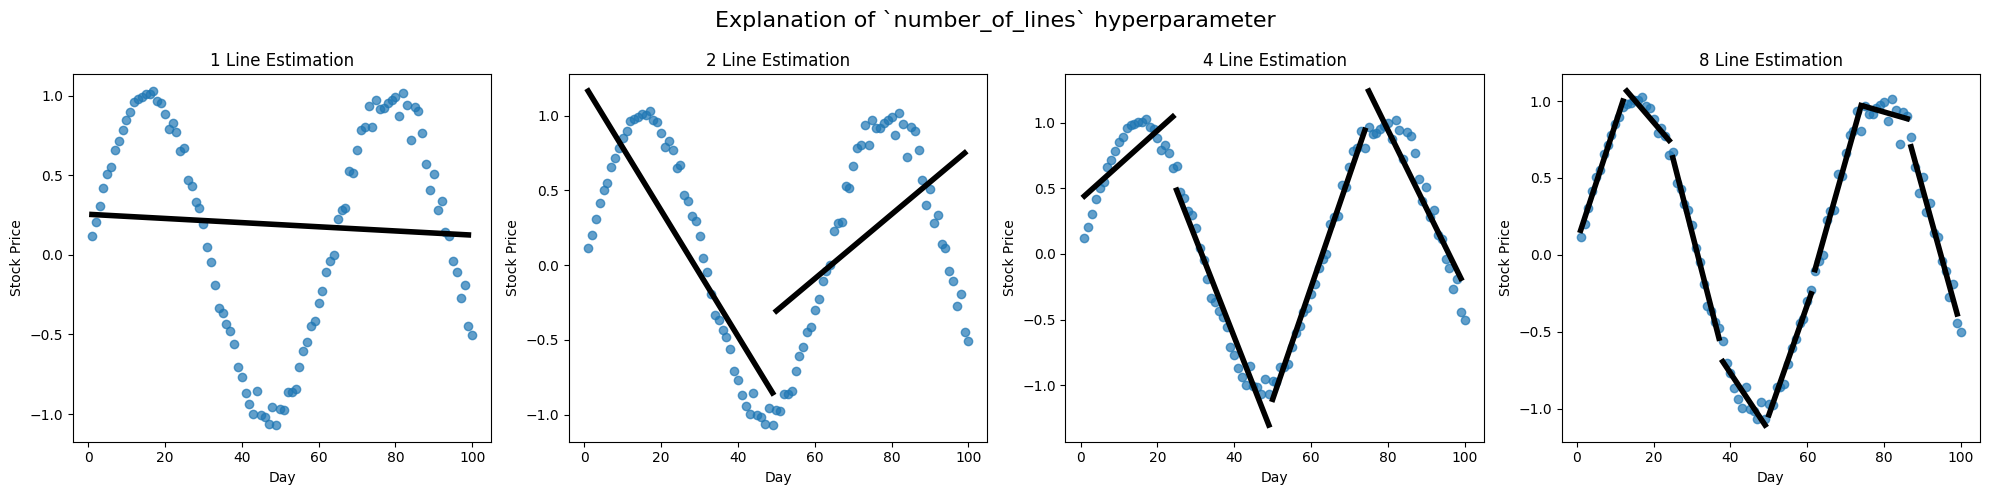

In [11]:
# Synthetic dataset mimicking daily stock data.
np.random.seed(0)  # For reproducibility
x = np.linspace(1, 100, 100)
y = np.sin(x / 10) + np.random.normal(0, 0.1, 100) * np.linspace(0.1, 1, 100)

lines_counts = [1, 2, 4, 8]

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=100)

for ax, lines_count in zip(axs, lines_counts):
    ax.scatter(x, y, alpha=0.7)
    
    # Determining indices for splitting the data to create 'lines_count' segments
    indices = np.linspace(0, len(x) - 1, lines_count + 1, dtype=int)
    
    for i in range(len(indices) - 1):
        # Extracting segments based on calculated indices
        segment_x = x[indices[i]:indices[i+1]]
        segment_y = y[indices[i]:indices[i+1]]
        
        # Fit a simple linear regression (polyfit) for each segment
        p = np.polyfit(segment_x, segment_y, 1)
        
        # Plotting the line
        ax.plot(segment_x, np.polyval(p, segment_x), '-', linewidth=4, color='black')
    
    ax.set_title(f"{lines_count} Line Estimation")
    ax.set_xlabel('Day')
    ax.set_ylabel('Stock Price')

fig.suptitle('Explanation of `number_of_lines` hyperparameter', fontsize=16)
plt.tight_layout()
plt.show()

# 6. Train Neural Network Models

In [12]:
# Constants
MAX_EPOCHS = 50
PATIENCE = 5

The following function allows us to pre-process and create the data for the models using several different hyperparameters such as `number_of_lines`, `number_of_years_to_consider`, `cats_subset` and `features_subset`. It also allows us to adjust the model and training process with several different hyperparameters such as `layer`, `neuron`, `batch_size` and `technique`. 

In [13]:
def create_model(number_of_lines, number_of_years_to_consider, layer, neuron, batch_size, technique, cat_features_subset, num_features_subset, results = results):
    # Get name of next model (models are simply named 1,2,3,... and addition information about the model can be found in "results\overview\model results.csv")
    files = os.listdir(models_path)
    numbers = sorted([int(file_name[:-3]) for file_name in files])
    try:
        model_name =  str(numbers[-1] + 1)
    except IndexError:
        model_name = "1"
    
    # Get pre-processed model data
    model_data = prepare_model_data(cat_features_subset, num_features_subset, number_of_years_to_consider,number_of_lines)

    # Split the data into 60% train set, 20% valudation set and 20% test set (the test data will be used in the following notebook.)
    x_train, x_temp, y_train, y_temp = train_test_split(model_data.iloc[:,:-1], model_data.iloc[:,-1], test_size=0.4, random_state=42, shuffle=False)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

    # Normalize the data
    normalizer = Normalization(axis=-1, input_shape=[x_train.shape[1]])
    normalizer.adapt(x_train.to_numpy())

    # Model architecture
    model = Sequential()
    model.add(normalizer)
    for _ in range(layer):
        model.add(Dense(neuron, activation='relu', kernel_initializer='he_normal'))
        if technique == "dropout & batch" or technique == "batch regularisation":
            model.add(BatchNormalization())
        if technique == "dropout & batch" or technique == "dropout layers":
            model.add(Dropout(0.5))
    model.add(Dense(1))  # Output layer for regression
    
    # Compile the model
    model.compile(loss='mean_absolute_error', optimizer= Adam(learning_rate=0.00001), metrics=[RSquare()])
    
    # Callbacks
    checkpoint_cb = ModelCheckpoint(f"{models_path}/{model_name}.h5", monitor='val_loss', save_best_only=True,verbose=0, save_weights_only=False, mode = "min")
    early_stopping_cb = EarlyStopping(monitor = "val_loss", patience = PATIENCE, restore_best_weights=True, verbose = 0, min_delta = 0.01, mode = "min")
    # tensorboard_cb = tf.keras.callbacks.TensorBoard(f"{root_folder}/{details_folder}/{technique}/logs/{data_name}/{model_name}")
    # reducelr_cb = ReduceLROnPlateau(monitor='val_r_square', factor=0.5, patience=REDUCE_LR_PATIENCE, verbose = 0, mode = "max")

    # Train the model
    history = model.fit(
        x_train, y_train,
        validation_data = (x_val, y_val),
        verbose=1,
        epochs=MAX_EPOCHS,
        callbacks=[checkpoint_cb, early_stopping_cb], # , tensorboard_cb , reducelr_cb
        batch_size = batch_size)

    # Calculate validation loss and r-squared 
    model = tf.keras.models.load_model(f"{models_path}/{model_name}.h5")
    test_predictions = model.predict(x_val, batch_size=batch_size)
    val_loss = min(history.history["val_loss"])
    R2_score = r2_score(y_val, test_predictions)

    # Plot the training process and validation results and save figure
    plt.close("all")
    features_string = f"{cat_features_subset + num_features_subset}".replace("'","").replace(",","")
    fig = plot(history, y_val, len(results), test_predictions, R2_score)
    plt.savefig(
        f'{graphs_path}/{model_name}.png',
        bbox_inches='tight',
        dpi = 300
    )

    # Add result to `results` dataframe 
    total_neurons = layer * neuron
    new_row = pd.DataFrame([{"features": features_string,
                            "lines": number_of_lines,
                            "years": number_of_years_to_consider,
                            "layers": layer,
                            "neurons per layer": neuron,
                            "total neurons": total_neurons,
                            "batch size": batch_size,
                            "technique": technique,
                            "model name": model_name,
                            "val_loss": val_loss,
                            "val_r2": R2_score}])
    results = pd.concat([results, new_row], ignore_index=True)

    # Add results to "model results.csv"
    result_row = [features_string, number_of_lines, number_of_years_to_consider, layer, neuron, total_neurons, batch_size, technique, model_name, val_loss, R2_score]
    with open(f"{root_folder}/{overview_folder}/model results.csv", "a") as f:
        writer = csv.writer(f)
        writer.writerow(result_row)

In [14]:
# Create sets of hyperparameters to try

# Feature selection. Choose economic indicators that aren't heavily correlated based on notebook 2 
chosen_economic_indicators = [
    "BCI", "CCI", "CLI", "3 month interbank rate", "Construction", 
    "Consumer prices", "Manufacturing hourly earnings", "Industrial production", 
    "Long-term interest rate", "Narrow money", 
    "Car registrations",  "Total employment", 
]

# Settings for the new hyperparameters
number_of_lines_options = [5, 20, 50]
number_of_years_to_consider_options = [2, 3, 4]
layers_options = [2, 4, 6]
neuron_options = [16, 32]
batch_size_options = [1024]

# Initialize the hyperparameters dictionary
hyperparameters = {
    'number_of_lines': [],
    'number_of_years_to_consider': [],
    'layer': [],
    'neuron': [],
    'batch_size': [],
    'technique': [],
    'cat_features_subset': [],
    'num_features_subset': []
}

# Generate a subset of hyperparameters for demonstration
for lines in number_of_lines_options:
    for years in number_of_years_to_consider_options:
        for layer in layers_options:
            for neuron in neuron_options:
                for batch_size in batch_size_options:
                    hyperparameters['number_of_lines'].append(lines)
                    hyperparameters['number_of_years_to_consider'].append(years)
                    hyperparameters['layer'].append(layer)
                    hyperparameters['neuron'].append(neuron)
                    hyperparameters['batch_size'].append(batch_size)
                    hyperparameters['technique'].append('base')
                    hyperparameters['cat_features_subset'].append(["sectors"])
                    hyperparameters['num_features_subset'].append(chosen_economic_indicators)

# We also need base cases to compare to where we don't use any economic indicators
for lines in number_of_lines_options:
    for years in number_of_years_to_consider_options:
        for layer in layers_options:
            for neuron in neuron_options:
                for batch_size in batch_size_options:
                    hyperparameters['number_of_lines'].append(lines)
                    hyperparameters['number_of_years_to_consider'].append(years)
                    hyperparameters['layer'].append(layer)
                    hyperparameters['neuron'].append(neuron)
                    hyperparameters['batch_size'].append(batch_size)
                    hyperparameters['technique'].append('base')
                    hyperparameters['cat_features_subset'].append([])
                    hyperparameters['num_features_subset'].append([])

# Convert dictionary to df
hyperparameters_df = pd.DataFrame.from_dict(hyperparameters, orient='index').transpose()
hyperparameters_df.head()

,number_of_lines,number_of_years_to_consider,layer,neuron,batch_size,technique,cat_features_subset,num_features_subset
0,5,2,2,16,1024,base,[sectors],"[BCI, CCI, CLI, 3 month interbank rate, Constr..."
1,5,2,2,32,1024,base,[sectors],"[BCI, CCI, CLI, 3 month interbank rate, Constr..."
2,5,2,4,16,1024,base,[sectors],"[BCI, CCI, CLI, 3 month interbank rate, Constr..."
3,5,2,4,32,1024,base,[sectors],"[BCI, CCI, CLI, 3 month interbank rate, Constr..."
4,5,2,6,16,1024,base,[sectors],"[BCI, CCI, CLI, 3 month interbank rate, Constr..."


In [ ]:
# Create a model using each set of hyperparmeters in `hypterparameters_df`
for i in range(len(hyperparameters_df)):
    hyperparameters = hyperparameters_df.loc[i]
    create_model(*hyperparameters)